# <center> Обучение с учителем. Регрессия
## <center> Предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

In [21]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 

import function_model_1 as fm1 #библиотека с нашими функциями


### Анализ требований

Задание: Построить ML-модели(LinearRegression, Lasso, Ridge), которые будут предсказывать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

**Знакомство с данными**

In [22]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Набор данных содержит следующие столбцы:
* age — возраст страхователя;
* sex — пол;
* bmi — индекс массы тела (
к
г
м
), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.


In [23]:
data.shape

(1338, 7)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [25]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [26]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропусков в наше наборе данных нет - отлично

### Исследование данных

In [27]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [28]:
temp_data = data.copy()

Проведем небольшое исследование зависимости таргета от числовых признаков. Для этого, построим гистограммы и диаграммы рассеяния.

In [29]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

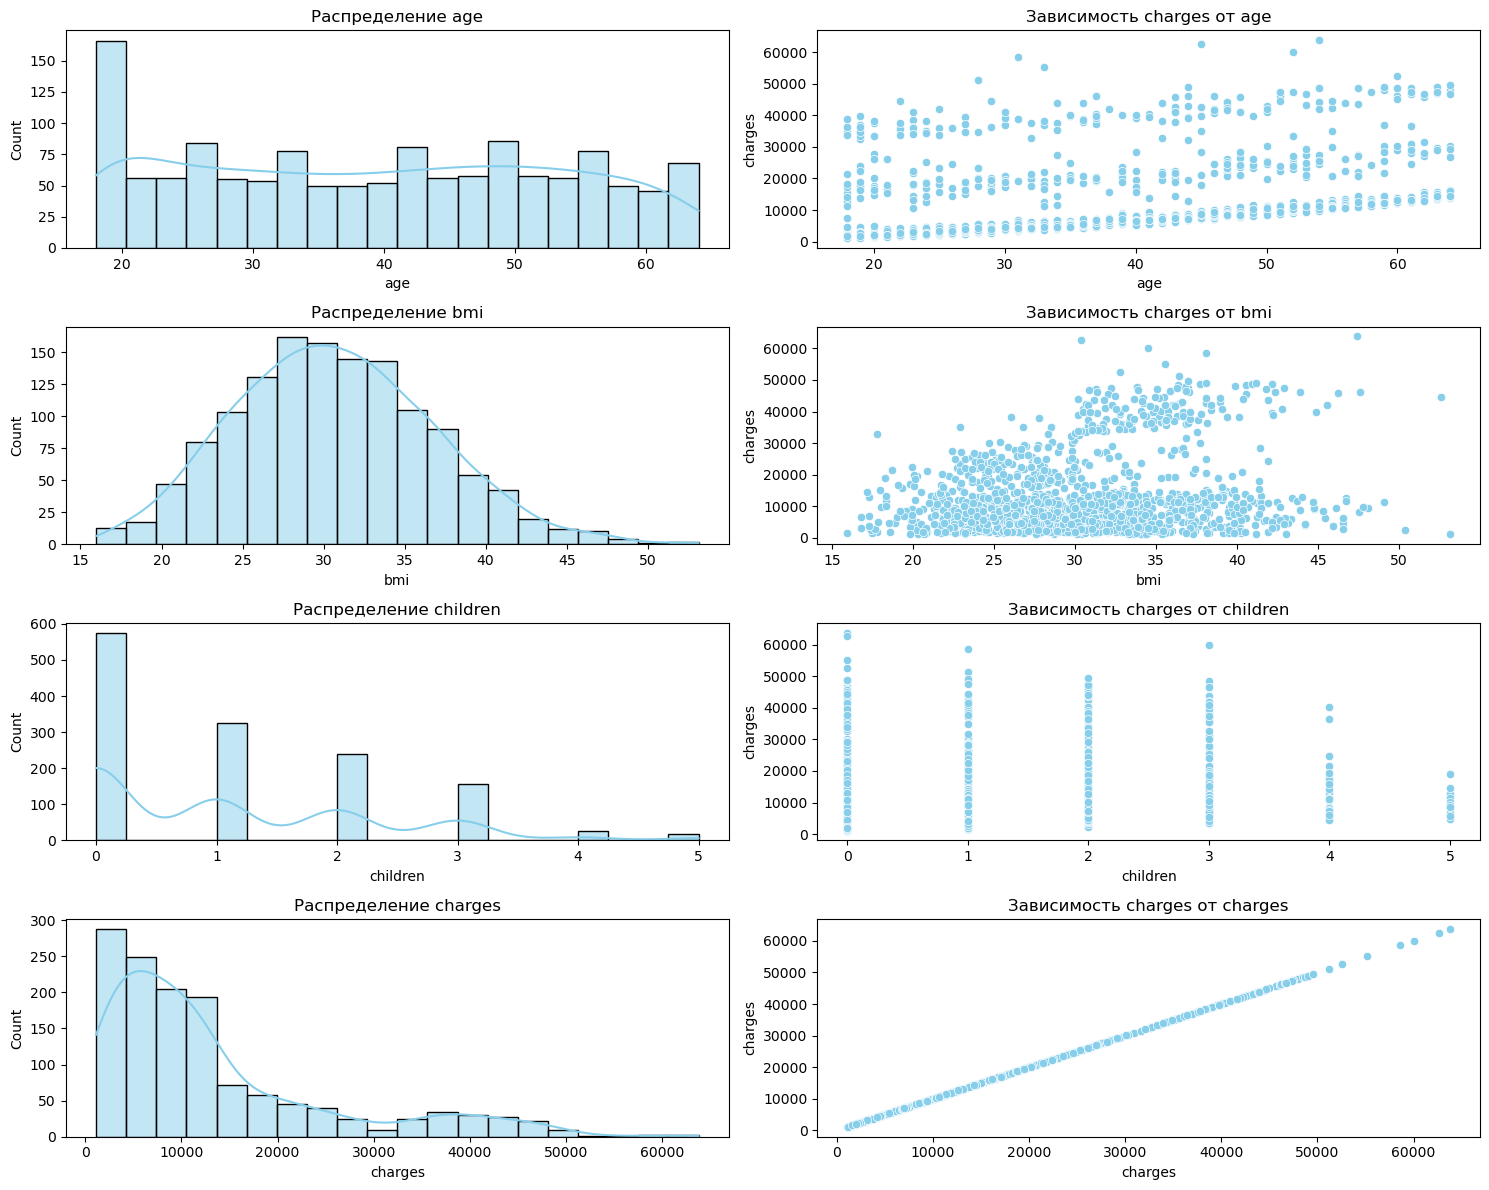

In [30]:
# Настройка сетки графиков
fig, ax = plt.subplots(nrows=len(num_features), ncols=2, figsize=(15, 12)) 

# Построение гистограмм и диаграмм рассеяния
for i, feature in enumerate(num_features):
    # Гистограма
    sns.histplot(data=temp_data, x=feature, ax=ax[i, 0], kde=True, bins=20, color='skyblue')
    ax[i, 0].set_title(f'Распределение {feature}')
    
    # Диаграмма рассеяния
    sns.scatterplot(data=temp_data, x=feature, y='charges', ax=ax[i, 1], color='skyblue')
    ax[i, 1].set_title(f'Зависимость charges от {feature}')

plt.tight_layout()


Видим, что bmi - это единственный признак, который имеет нормальное распределение(график в виде колокола). Имеем положительную коррелляцию таргета charges и факторами bmi с age. 
Теперь построим матрицу корреляцииб чтобы оценить мультиколлинеарную зависимость и линейную зависимость между факторами и таргетами

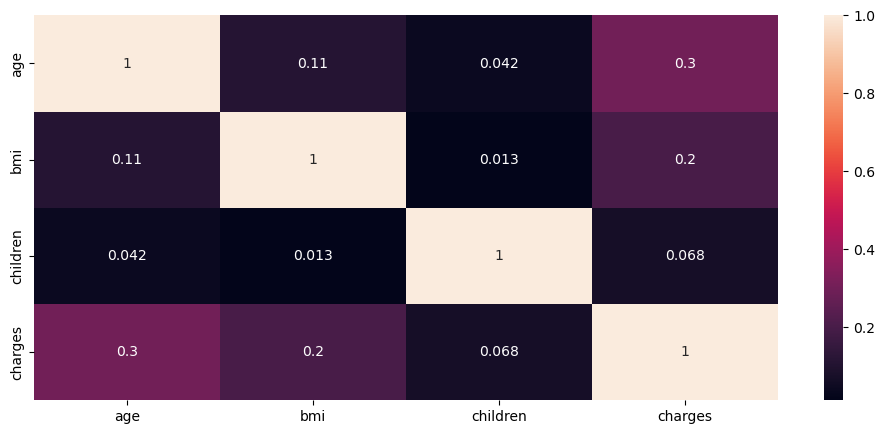

In [31]:
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data.corr(numeric_only=True), annot=True);

Как можно заметить, наши факторы не создают мультиколлениарность. Значение корреляции между факторами находятся в промежутке от 0 до 0.2 - что говорит о том, что связи очень слабая или ее вообще нет. 
Также, как писалось до этого bmi и age имеют положительную корреляцию с charges. Корреляция между факторами и таргетом имеет слабый/очень слабый уровень связи.

Из этого следует, что мы можем использовать все признаки в модели без дополнительной оработки, т.к риск мультиколлинеарности близок или равен 0.

*Проведем исследования котегориальных данных*

In [32]:
types = temp_data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['sex', 'smoker', 'region']

/tmp/ipykernel_112150/1361104601.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=feature, y='charges', ax=ax[i], estimator='median', palette='viridis')
/tmp/ipykernel_112150/1361104601.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=feature, y='charges', ax=ax[i], estimator='median', palette='viridis')
/tmp/ipykernel_112150/1361104601.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=feature, y='charges', ax=ax[i], estimator='median', palette='viridis')


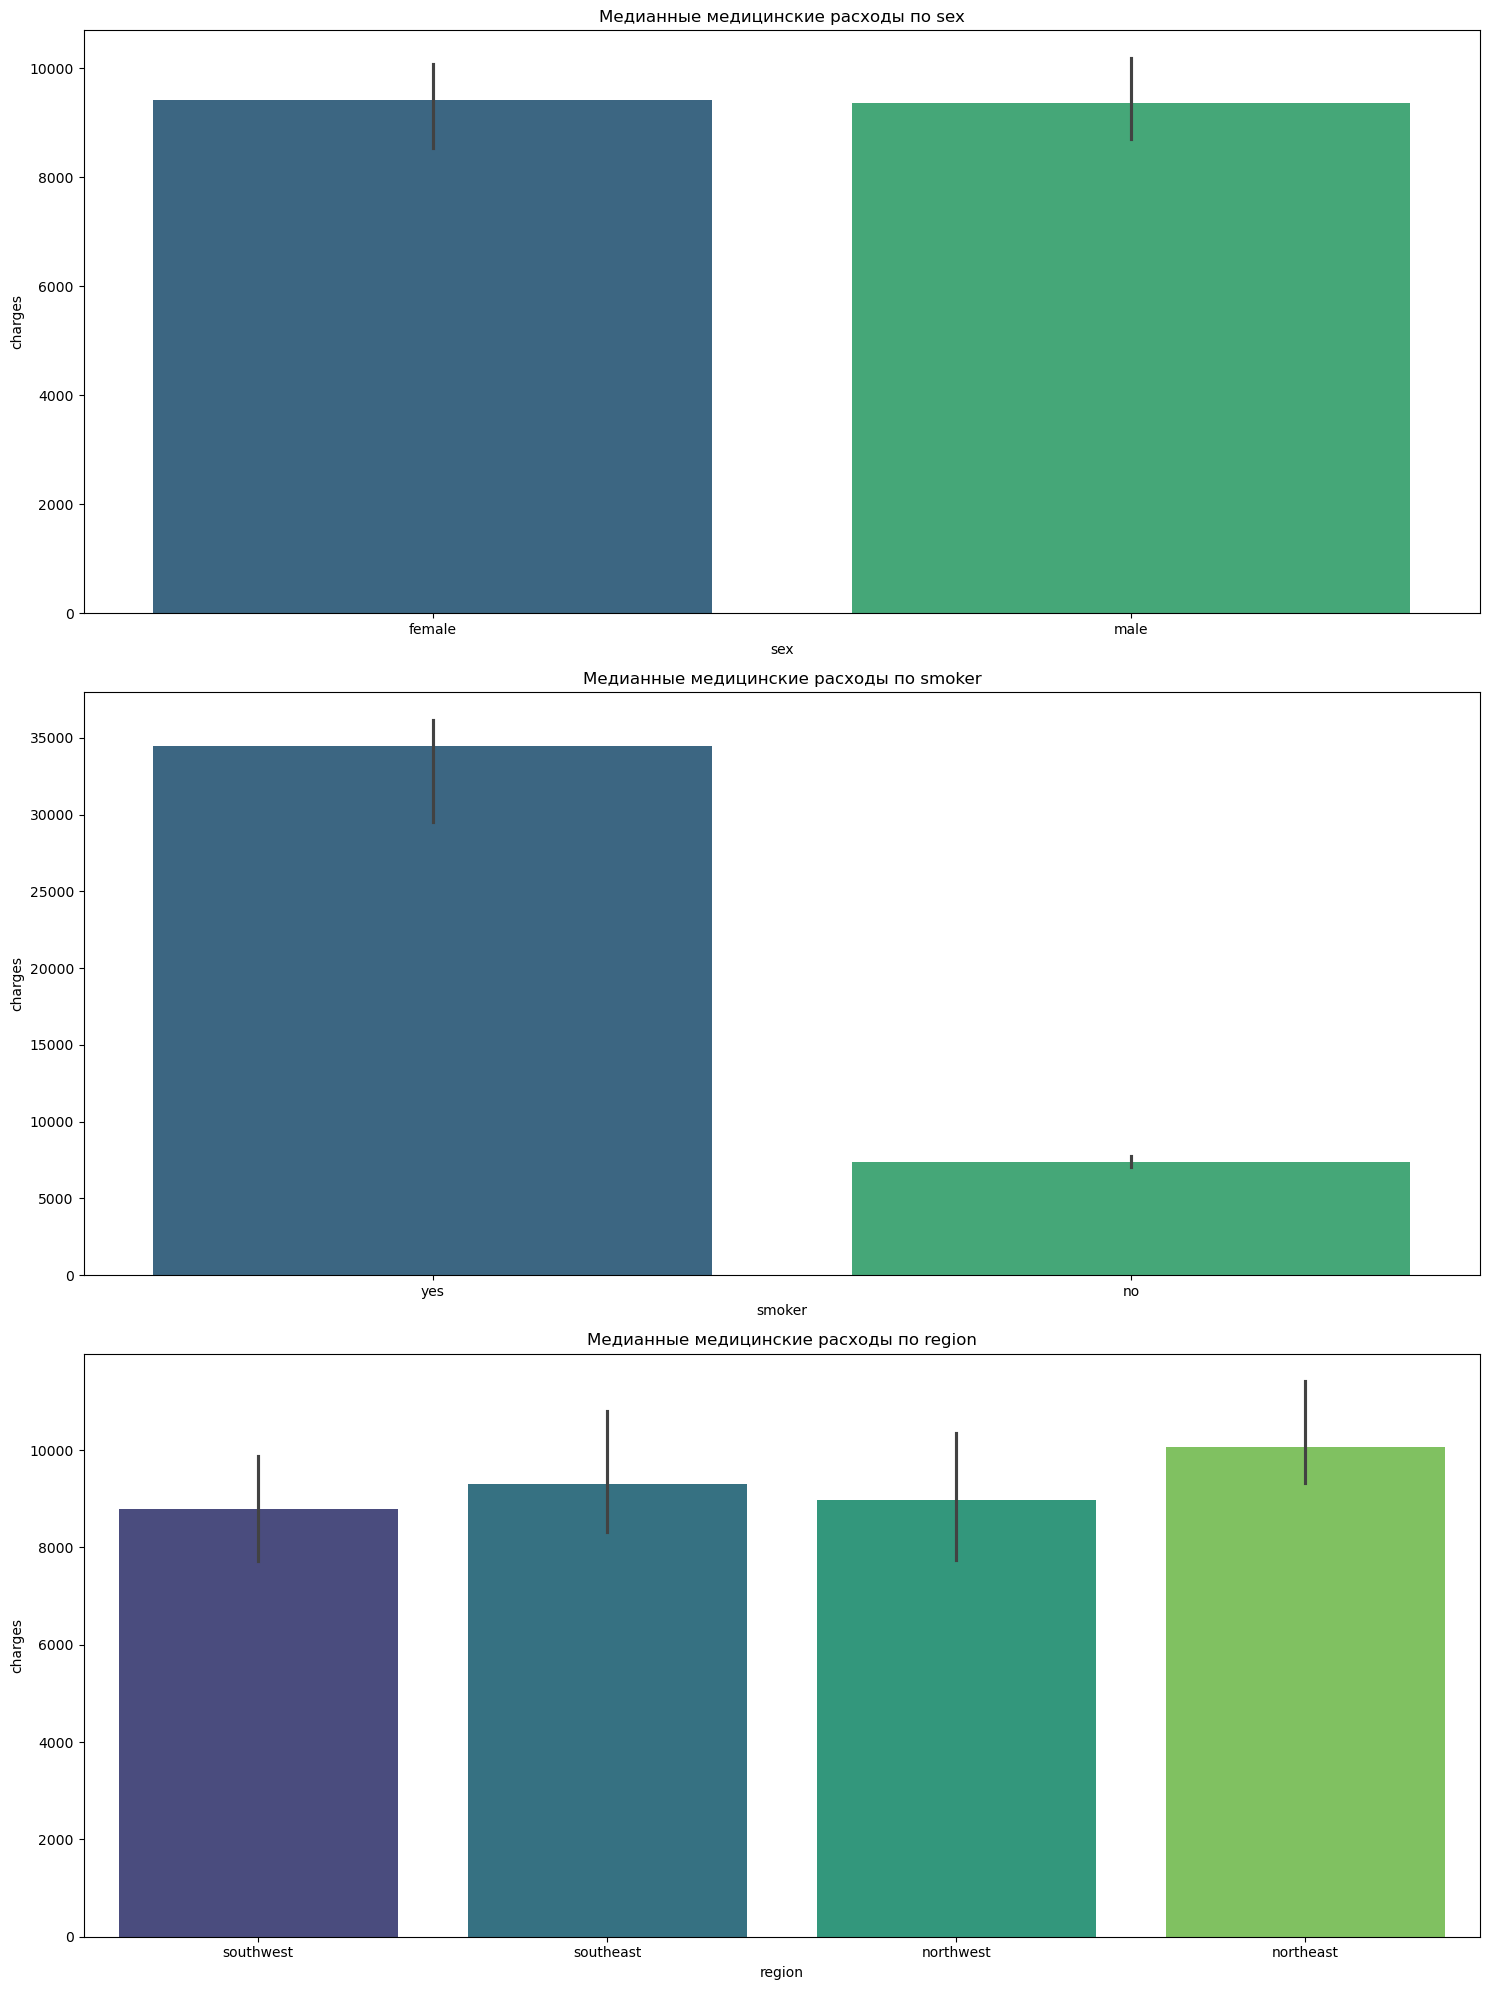

In [33]:
fig, ax = plt.subplots(nrows=len(cat_features), figsize=(15,20))


for i, feature in enumerate(cat_features):
    sns.barplot(data=data, x=feature, y='charges', ax=ax[i], estimator='median', palette='viridis')
    ax[i].set_title(f'Медианные медицинские расходы по {feature}')

plt.tight_layout()

In [34]:
temp_data.groupby('smoker')['charges'].median()

smoker
no      7345.40530
yes    34456.34845
Name: charges, dtype: float64

Можем заметить, что в отличии от кат. фактора smoker, расходы примерно равны по категориям.
У курящих детей расходы на индивидуальные медицинские услуги выше в примерно 4 раза, по сравнению с некурящими.

### Подготовка данных

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

* smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* sex — аналогично (0 — female, 1 — male);
* region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [35]:
temp_data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
temp_data['sex'] = temp_data['sex'].apply(lambda x: 0 if x == 'female' else 1)
temp_data = pd.get_dummies(temp_data)

Проведем исследование данных на выбросы

Избавимся от выбросов с помощью метода z-отклонений на логарифмированных признаках. 

Напомним, метод z-отклонений мы изучали в модуле по очистке данных

In [36]:
num_features
outliers, temp_cleaned = fm1.outliers_z_score(temp_data, 'bmi', log_scale=False)
outliers, temp_cleaned = fm1.outliers_z_score(temp_cleaned, 'charges', log_scale=True)
outliers, temp_cleaned = fm1.outliers_z_score(temp_cleaned, 'age', log_scale=True)

In [37]:
display(temp_data.shape, temp_cleaned.shape)

(1338, 10)

(1334, 10)

Разделим факторы и таргет

In [38]:
features = temp_data.drop('charges', axis=1).columns
X, y = temp_data[features], temp_data['charges']


Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


### Моделирование + Оценка модели

**Модель линейной регрессии:**

In [42]:
#Создаем и обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

#Строим таблицу с нашими весами и выводи ее
weight_df = pd.DataFrame({'Features': features, 'Weight': model.coef_})
w_0 = pd.DataFrame({'Features': ['Intercept'], 'Weight': [model.intercept_]})
data_of_weight = pd.concat([w_0, weight_df], axis=0).reset_index(drop=True)
display(data_of_weight)

#Делаем предсказание
y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)

,Features,Weight
0,Intercept,-12390.804295
1,age,256.975706
2,sex,-18.591692
3,bmi,337.092552
4,children,425.278784
5,smoker,23651.128856
6,region_northeast,459.585244
7,region_northwest,88.907918
8,region_southeast,-198.279052
9,region_southwest,-350.214110


In [43]:
print('Test sample:')
fm1.print_metrics(y_test, y_test_predict)
print('Train sample:')
fm1.print_metrics(y_train, y_train_predict)

Test sample:
Train R^2: 0.784
Train MAE: 4181.194
Train MAPE: 46.9
Train sample:
Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.2


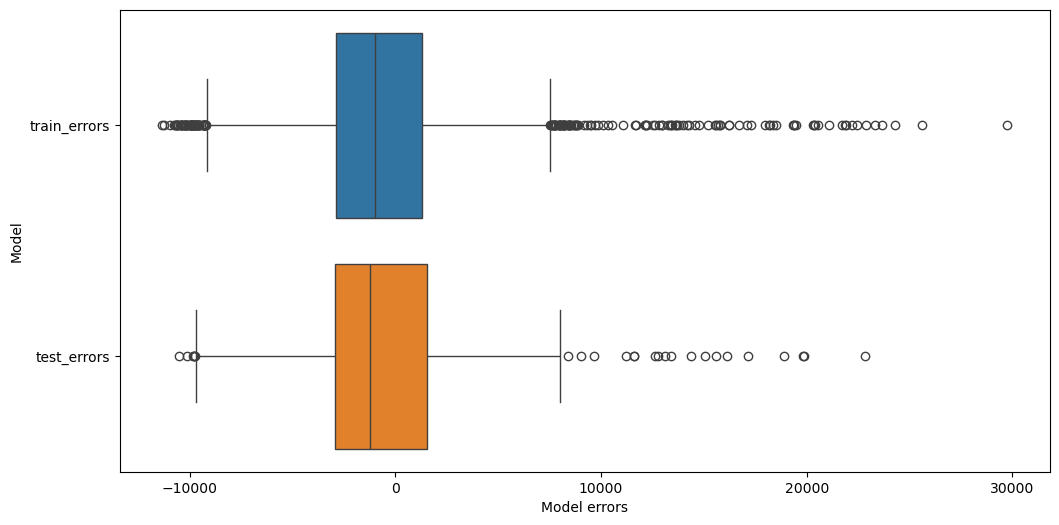

In [44]:
train_errors = y_train - y_train_predict
test_errors = y_test - y_test_predict

fig, ax = plt.subplots(figsize=(12, 6))

errors_df = pd.DataFrame(
    {'train_errors': train_errors, 
     'test_errors': test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат



Построив диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках, можем сделать выводы:
* Разброс ошибок на тренировочной выборке больше, чем на тестовой
* Медианная ошибка на тренировочной и тестовой выборках отрицательна.

Неплохой результат. Поробуем улучшить их, при помощи нормализации

In [55]:
minmax = preprocessing.MinMaxScaler()
minmax.fit(X_test)
X_test_norm = minmax.transform(X_test)
X_train_norm = minmax.transform(X_train)

Используем полином 2 степени, для улучшения результатов

In [56]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_norm)
X_train_poly = poly.transform(X_train_norm)
X_test_poly = poly.transform(X_test_norm)

In [57]:
X_test_poly.shape[1]

54

In [58]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

y_test_predict_poly = model.predict(X_test_poly) 

In [59]:
fm1.print_metrics(y_test, y_test_predict_poly)

Train R^2: 0.867
Train MAE: 2729.500
Train MAPE: 30.2


Мы уменьшели ошибку, посмотрим на коэфициенты модели.

In [60]:
display(model.coef_)

array([ 2867.67323498,  -410.62102238,  5367.65513656,  4664.79011382,
        1699.78683011,   378.29513577,  -351.74245762,   200.8813428 ,
        -227.43402096,  8399.63608632,   812.46558472,   958.050265  ,
       -1666.91118191,   172.50303109,  -843.44188403,   285.42389587,
        1460.50362021,  1965.18760294,  -410.62102238,   623.00066334,
       -1238.19812114,   257.33745404,  -965.02398422,   313.4780531 ,
         545.86949793,  -304.94458918, -8990.73725281,  1500.91004515,
       52766.32867022,  3553.08384904,  2575.33993747,  -850.6592361 ,
          89.89058616, -2090.61756751, -2233.48411893,  2445.23907884,
        2470.83358704,   417.42922965,  -668.71178171,  1699.78683011,
         458.72097813,  -158.64890543,  -449.82255277,  1849.53731019,
         378.29513577,     0.        ,     0.        ,     0.        ,
        -351.74245762,     0.        ,     0.        ,   200.8813428 ,
           0.        ,  -227.43402096])

Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация

In [62]:
model_l1 = Lasso(max_iter=2000)
model_l1.fit(X_train_poly, y_train)

y_test_predict_poly_las = model_l1.predict(X_test_poly) 

In [63]:
fm1.print_metrics(y_test, y_test_predict_poly_las)

Train R^2: 0.867
Train MAE: 2719.789
Train MAPE: 30.1


In [73]:
y_train_log = np.log(y_train)

In [74]:
model_R = Ridge()
model_R.fit(X_train_poly, y_train_log)

y_test_predict_poly_rid = np.exp(model_R.predict(X_test_poly))

In [75]:
fm1.print_metrics(y_test, y_test_predict_poly_rid)

Train R^2: 0.857
Train MAE: 2419.678
Train MAPE: 17.9


Качество модели можно улучшить, если подробовать подобрать оптимальное значение коэффициента регуляризации $\alpha$ (по умолчанию в реализации sklearn $\alpha = 1$). Нас интересует такое значение коэффициента, при котором наблюдается наилучшее значение метрики на тестовой выборке (наименьшее значение MAE), если таких значений $\alpha$ несколько, то берем то, при котором разница в показателях на тренировочной и тестовой выборке наименьшая.

In [76]:
alpha_list = np.linspace(0.01, 10, 20)
train_scores = []
test_scores = []
for alpha in alpha_list:
    model_R = Ridge(alpha=alpha, max_iter=10000)
    model_R.fit(X_train_poly, y_train_log)
    y_test_predict_poly_rid = np.exp(model_R.predict(X_test_poly))
    y_train_predict_poly_rid = np.exp(model_R.predict(X_train_poly))
    
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly_rid))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly_rid))    

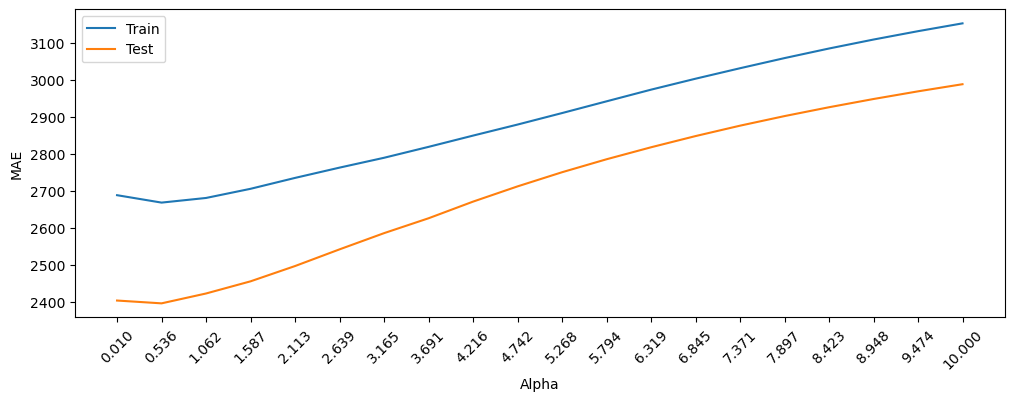

In [70]:
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

Наилучшее значение метрики соотвествует alpha=0.536

In [86]:
model_R = Ridge(alpha=0.536)
model_R.fit(X_train_poly, y_train_log)

y_test_predict_poly_rid = np.exp(model_R.predict(X_test_poly))

In [87]:
fm1.print_metrics(y_test, y_test_predict_poly_rid)

Train R^2: 0.857
Train MAE: 2396.066
Train MAPE: 17.6


Возможные дальнейшие шаги по улучшению:
* feature engineering - попыться сгенерировать новые признаки в данных/присоединить внешние источники
* попытаться привести все числовые признаки к нормальному распределению (например, с помощью логарифмирования)
* найти наблюдения, для которых наблюдается высокая ошибка между предсказанием и действительностью и понять, что с ними "не так"